In [524]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [525]:
df=pd.read_csv('vcb_24.csv',index_col='DATE')
df.index = pd.to_datetime(df.index, dayfirst=True)
df = df.sort_index()
df=df[['CLOSE']]
df

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19504\58636171.py:2: UserWarning: Parsing dates in %m/%d/%Y format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df.index = pd.to_datetime(df.index, dayfirst=True)


,CLOSE
DATE,
2015-01-05,15680
2015-01-06,16713
2015-01-07,16516
2015-01-08,17008
2015-01-09,18138
...,...
2024-04-22,90600
2024-04-23,90100
2024-04-24,90600


In [526]:
# Chia dữ liệu thành train và test theo tỉ lệ 8:2
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

# Tạo dữ liệu theo ngày dự đoán
def create_graph_data(df, window_size):
    X = []
    y = []
    for i in range(len(df) - window_size-1):
        X.append(df.iloc[i:i+window_size, 0])
        y.append(df.iloc[i+window_size, 0])
    return torch.tensor(X, dtype=torch.float), torch.tensor(y, dtype=torch.float)

window_size = 60
X_train, y_train = create_graph_data(train_df, window_size)
X_test, y_test=create_graph_data(test_df, window_size)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19504\807319890.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return torch.tensor(X, dtype=torch.float), torch.tensor(y, dtype=torch.float)


In [527]:
# Tạo DataLoader để phân lô (batching)
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [528]:
# Định nghĩa mô hình TCN
class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        self.tcn = nn.Sequential(
            nn.Conv1d(input_size, num_channels, kernel_size=kernel_size, padding=(kernel_size - 1) // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(num_channels, num_channels, kernel_size=kernel_size, padding=(kernel_size - 1) // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(num_channels, num_channels, kernel_size=kernel_size, padding=(kernel_size - 1) // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(num_channels, output_size, kernel_size=1)
        )

    def forward(self, x):
        return self.tcn(x)

In [529]:
# Khởi tạo mô hình
input_size = X_train.shape[1]
output_size = 1  # Dự đoán một giá trị (CLOSE)
num_channels = 128
kernel_size = 3
dropout = 0.01
learning_rate = 0.001
epochs = 400

model = TCN(input_size, output_size, num_channels, kernel_size, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

TCN(
  (tcn): Sequential(
    (0): Conv1d(60, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Dropout(p=0.01, inplace=False)
    (3): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): Dropout(p=0.01, inplace=False)
    (6): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): ReLU()
    (8): Dropout(p=0.01, inplace=False)
    (9): Conv1d(128, 1, kernel_size=(1,), stride=(1,))
  )
)

In [530]:
#  Huấn luyện mô hình TCN
for epoch in range(epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X.permute(1,0 ))  # TCN yêu cầu (batch_size, input_size, sequence_length)
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Đánh giá mô hình
model.eval()
with torch.no_grad():
    X_test = X_test.to(device)
    y_pred = model(X_test.permute(1,0)).cpu().numpy()

Epoch [1/400], Loss: 327702464.0000
Epoch [2/400], Loss: 70804992.0000
Epoch [3/400], Loss: 13021454.0000
Epoch [4/400], Loss: 22770670.0000
Epoch [5/400], Loss: 32657352.0000
Epoch [6/400], Loss: 4556406.0000
Epoch [7/400], Loss: 27097112.0000
Epoch [8/400], Loss: 10350455.0000
Epoch [9/400], Loss: 12943096.0000
Epoch [10/400], Loss: 596226.7500
Epoch [11/400], Loss: 6851457.0000
Epoch [12/400], Loss: 2337923.0000
Epoch [13/400], Loss: 9560107.0000
Epoch [14/400], Loss: 6931259.5000
Epoch [15/400], Loss: 647202.1250
Epoch [16/400], Loss: 1330816.3750
Epoch [17/400], Loss: 10362685.0000
Epoch [18/400], Loss: 5049407.5000
Epoch [19/400], Loss: 1619722.7500
Epoch [20/400], Loss: 1522102.0000
Epoch [21/400], Loss: 6758521.0000
Epoch [22/400], Loss: 2453110.2500
Epoch [23/400], Loss: 9525263.0000
Epoch [24/400], Loss: 4621590.0000
Epoch [25/400], Loss: 2497275.7500
Epoch [26/400], Loss: 2177015.7500
Epoch [27/400], Loss: 3135291.0000
Epoch [28/400], Loss: 5179030.5000
Epoch [29/400], Loss:

In [531]:
y_pred_flat = y_pred.flatten()
df_pred = pd.DataFrame({'Pre': y_pred_flat})
df_pred['CLOSE']=y_test


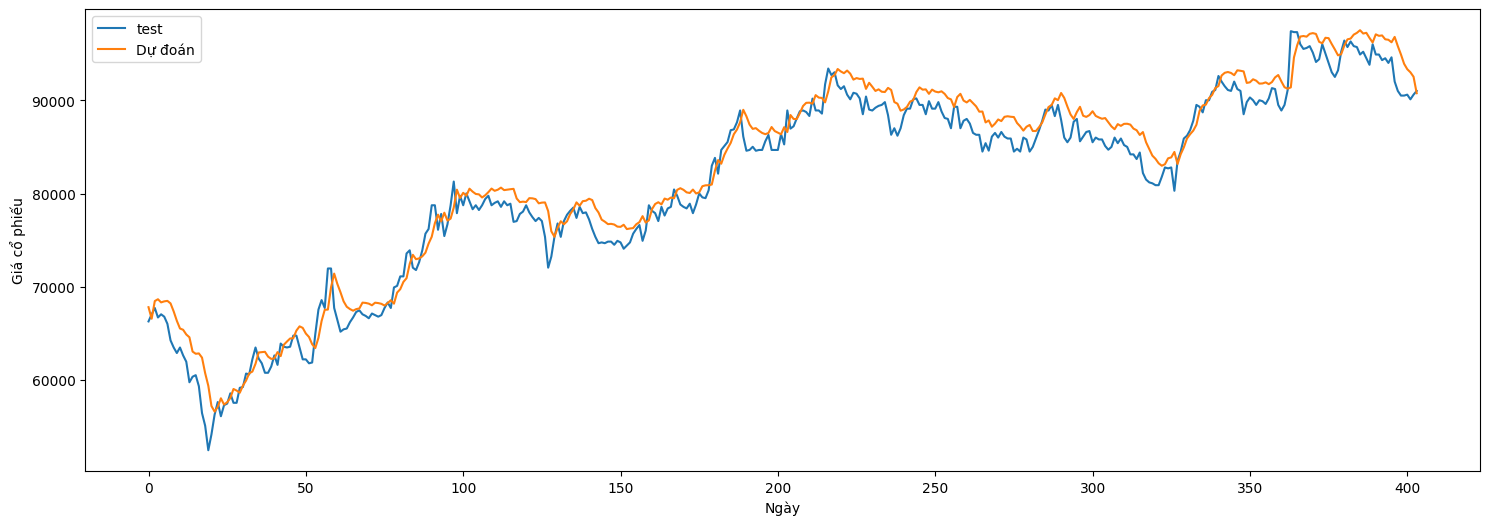

R²: 0.9587
MAE: 1766.5386
NSE: 0.9587
RMSE: 2125.6125


In [532]:
plt.figure(figsize=(18, 6))
plt.plot(df_pred.index, df_pred['CLOSE'], label='test')
plt.plot(df_pred.index, df_pred['Pre'], label='Dự đoán')
plt.xlabel('Ngày')
plt.ylabel('Giá cổ phiếu')
plt.legend()
plt.show()

y_true = df_pred['CLOSE']
y_pred = df_pred['Pre']
# Đánh giá mô hình
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
nse = 1 - (np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2))

print(f'R²: {r2:.4f}')
print(f'MAE: {mae:.4f}')
print(f'NSE: {nse:.4f}')
print(f'RMSE: {rmse:.4f}')

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19504\4178354102.py:2: UserWarning: Parsing dates in %m/%d/%Y format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df.index = pd.to_datetime(df.index, dayfirst=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19504\807319890.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return torch.tensor(X, dtype=torch.float), torch.tensor(y, dtype=torch.float)


Epoch [1/400], Loss: 53163828.0000
Epoch [2/400], Loss: 23677702.0000
Epoch [3/400], Loss: 8854261.0000
Epoch [4/400], Loss: 8042730.0000
Epoch [5/400], Loss: 4632717.0000
Epoch [6/400], Loss: 11329976.0000
Epoch [7/400], Loss: 8745424.0000
Epoch [8/400], Loss: 6658298.0000
Epoch [9/400], Loss: 11401424.0000
Epoch [10/400], Loss: 8017962.5000
Epoch [11/400], Loss: 8856888.0000
Epoch [12/400], Loss: 5643541.0000
Epoch [13/400], Loss: 3687344.7500
Epoch [14/400], Loss: 3641208.5000
Epoch [15/400], Loss: 5253846.5000
Epoch [16/400], Loss: 2635037.7500
Epoch [17/400], Loss: 5945908.5000
Epoch [18/400], Loss: 3745264.0000
Epoch [19/400], Loss: 2721414.7500
Epoch [20/400], Loss: 7366048.5000
Epoch [21/400], Loss: 4260812.5000
Epoch [22/400], Loss: 2609283.2500
Epoch [23/400], Loss: 3490687.5000
Epoch [24/400], Loss: 4115904.0000
Epoch [25/400], Loss: 3056558.5000
Epoch [26/400], Loss: 4290655.0000
Epoch [27/400], Loss: 6947934.0000
Epoch [28/400], Loss: 1919942.5000
Epoch [29/400], Loss: 455

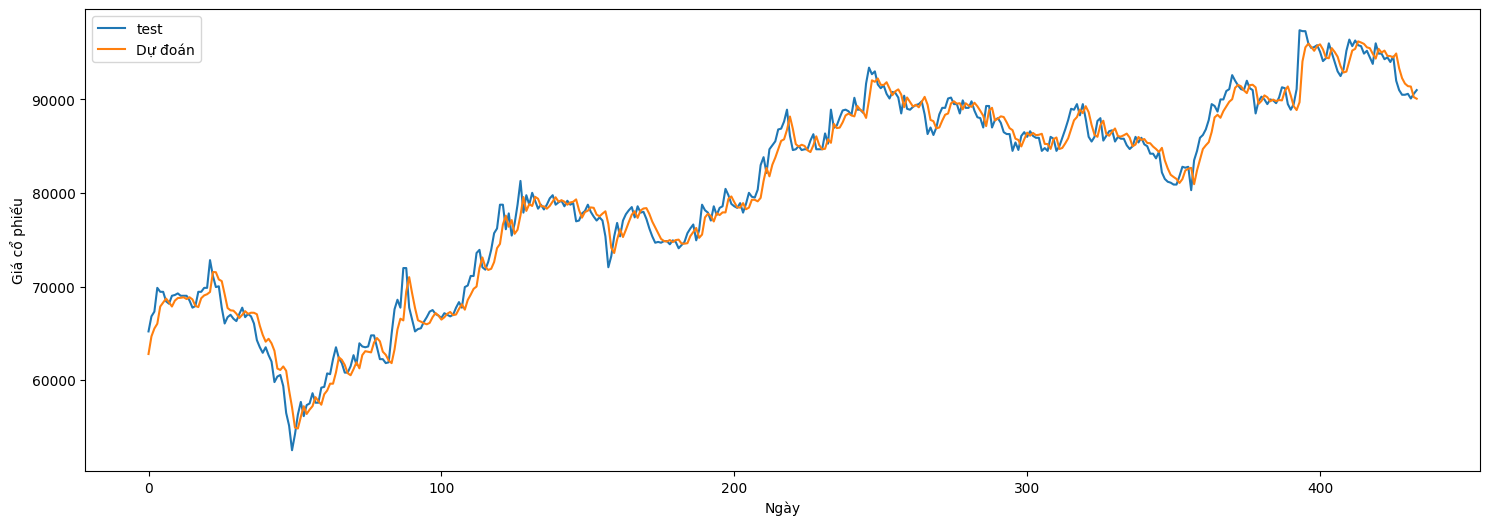

In [533]:
df=pd.read_csv('vcb_24.csv',index_col='DATE')
df.index = pd.to_datetime(df.index, dayfirst=True)
df = df.sort_index()
df=df[['CLOSE']]

# Chia dữ liệu thành train và test theo tỉ lệ 8:2
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

window_size = 30
X_train, y_train = create_graph_data(train_df, window_size)
X_test, y_test=create_graph_data(test_df, window_size)
# Tạo DataLoader để phân lô (batching)
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# Định nghĩa mô hình TCN
class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        self.tcn = nn.Sequential(
            nn.Conv1d(input_size, num_channels, kernel_size=kernel_size, padding=(kernel_size - 1) // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(num_channels, num_channels, kernel_size=kernel_size, padding=(kernel_size - 1) // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(num_channels, num_channels, kernel_size=kernel_size, padding=(kernel_size - 1) // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(num_channels, output_size, kernel_size=1)
        )

    def forward(self, x):
        return self.tcn(x)
    
    #  Huấn luyện mô hình TCN
input_size = X_train.shape[1]
output_size = 1  # Dự đoán một giá trị (CLOSE)
num_channels = 128
kernel_size = 3
dropout = 0.01
learning_rate = 0.001
epochs = 400

model = TCN(input_size, output_size, num_channels, kernel_size, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X.permute(1,0 ))  # TCN yêu cầu (batch_size, input_size, sequence_length)
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Đánh giá mô hình
model.eval()
with torch.no_grad():
    X_test = X_test.to(device)
    y_pred = model(X_test.permute(1,0)).cpu().numpy()
y_pred_flat = y_pred.flatten()

df_pred1 = pd.DataFrame({'Pre': y_pred_flat})
df_pred1['CLOSE']=y_test

plt.figure(figsize=(18, 6))
plt.plot(df_pred1.index, df_pred1['CLOSE'], label='test')
plt.plot(df_pred1.index, df_pred1['Pre'], label='Dự đoán')
plt.xlabel('Ngày')
plt.ylabel('Giá cổ phiếu')
plt.legend()
plt.show()

y_true = df_pred1['CLOSE']
y_pred = df_pred1['Pre']
# Đánh giá mô hình
r21 = r2_score(y_true, y_pred)
mae1 = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse1 = np.sqrt(mse)
nse1 = 1 - (np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2))



In [534]:
print(f'R²: {r21:.4f}')
print(f'MAE: {mae1:.4f}')
print(f'NSE: {nse1:.4f}')
print(f'RMSE: {rmse1:.4f}')

R²: 0.9791
MAE: 1140.3651
NSE: 0.9791
RMSE: 1525.3153


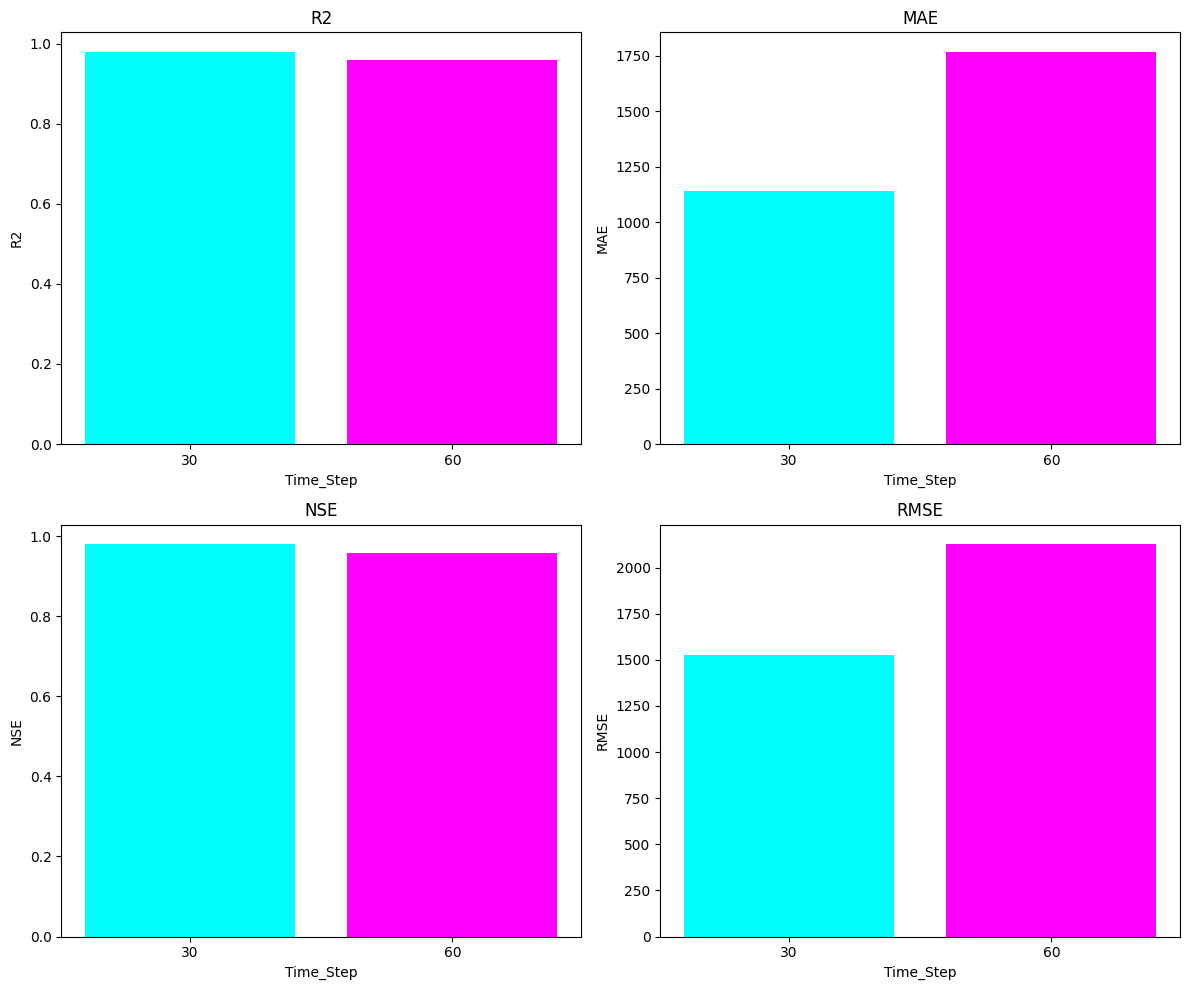

In [538]:
import matplotlib.pyplot as plt

# Dữ liệu
labels1 = ['30', '60']
values1 = [r21, r2]

labels2 = ['30', '60']
values2 = [mae1, mae]

labels3 = ['30', '60']
values3 = [nse1, nse]

labels4 = ['30', '60']
values4 = [rmse1, rmse]

# Tạo figure và các subplot
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Vẽ biểu đồ cột cho từng nhóm dữ liệu
axs[0, 0].bar(labels1, values1, color=['red', 'magenta'])
axs[0, 0].set_title('R2')
axs[0, 0].set_xlabel('Time_Step')
axs[0, 0].set_ylabel('R2')

axs[0, 1].bar(labels2, values2, color=['red', 'magenta'])
axs[0, 1].set_title('MAE')
axs[0, 1].set_xlabel('Time_Step')
axs[0, 1].set_ylabel('MAE')

axs[1, 0].bar(labels3, values3, color=['red', 'magenta'])
axs[1, 0].set_title('NSE')
axs[1, 0].set_xlabel('Time_Step')
axs[1, 0].set_ylabel('NSE')

axs[1, 1].bar(labels4, values4, color=['red', 'magenta'])
axs[1, 1].set_title('RMSE')
axs[1, 1].set_xlabel('Time_Step')
axs[1, 1].set_ylabel('RMSE')

# Tinh chỉnh layout
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()
